In [ ]:
"""
Author: Joe Zavorskas
Date Started: 6/26/2023
Last Edit: 04/11/2024

"""

In [1]:
# Import necessary packages:
import cobra
from cobra.io import save_matlab_model,write_sbml_model
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
from datetime import datetime, timedelta
from scipy.interpolate import RegularGridInterpolator
import netCDF4
from IPython.display import clear_output

# Author-written functions:
import DaySolve, NightSolve, fluxCalc, LoadModel, Light, Extras

In [2]:
# Initialize a dictionary to hold all inputs to the class.
Inputs = {}

# User defined inputs here!!! Names will be more descriptive in this user-facing section.
Inputs['Year'] = 2024
Inputs['DayNumber'] = 0 # Daynumber 0 is a flag for not using DAYNUM/YY mode.
Inputs['Month'] = 5 # Month 0 is a flag for not using MM/DD/YYYY mode.
Inputs['Day'] = 1 # Day 0 is a flag for not using MM/DD/YYYY mode.
Inputs['Hour'] = 12 # 24-hour time
Inputs['Minute'] = 0
Inputs['Second'] = 0
Inputs['Interval'] = 0 # Defaults to zero. Do not change, interval will be handed in dFBA.
Inputs['Latitude'] = 66.67 # Bottom of Arctic Circle
Inputs['Longitude'] = 0 # Prime Meridian
Inputs['Timezone'] = 0 # We are at the prime meridian. (This will be automatically calculated.)
Inputs['Pressure'] = 1013 # DEFAULT: 1013 mb = 1 atmosphere
Inputs['Temperature'] = 0 # DEFAULT: 10 deg C (arctic will be much colder)

Inputs['Turbidity'] = 0.084
Inputs['Water Vapor'] = 1.4164
Inputs['Ozone'] = 0.3438 # GET CITATIONS FOR THESE FROM ORIGINAL SMARTS2
Inputs['Albedo'] = 0.1 # Average albedo of ocean surface

# Input wavelength-dependent data tables.
Inputs['WVL-ETR'] = np.loadtxt('.\\Data\\WVL-ETR.csv',delimiter=',',dtype='float64', encoding='utf-8-sig')
Inputs['WVL-ABS'] = np.loadtxt('.\\Data\\WVL-ABS.csv',delimiter=',',dtype='float64', encoding='utf-8-sig')

# Create an object that will store data for wavelength-dependent light transmission through the atmosphere.
ICalc = Light.TotSolEng(Inputs)
# Calculate the total incident extraterrestrial radiation (ETR) based on date, time and location.
ICalc.CalcTotSolarEng(Inputs)
# Calculate wavelength-dependent light transmission based on ETR spectrum.
ICalc.CalcSolarSpec(Inputs)

# Calculate wavelength-dependent light absorption/scattering by the ocean at a certain depth.
ICalc.waterabs(0)
ICalc.DTOTphoto = np.asarray(ICalc.DTOTphoto).squeeze()

Inputs['Itot'] = scipy.integrate.simpson(ICalc.DTOTphoto,ICalc.allWVLphoto)

# Integrate only the photoactive region of the incident spectrum to get total photoactive light intensity.
Inputs['Iphoto'] = Extras.par(ICalc.DTOTphoto,ICalc.allWVLphoto)

start = str(Inputs['Month']).zfill(2) + "/" + str(Inputs['Day']).zfill(2) + "/" + str(Inputs['Year']) + " " + str(Inputs['Hour'])
start_date = datetime.strptime(start, "%m/%d/%Y %H")

In [5]:
Inputs['Itot']

295.2740270026375

In [6]:
ML = LoadModel.LoadModel(Inputs)

In [5]:
ML

In [ ]:
# Differential Equation function for IVP solver:
"""
y: [    Biomass     ]
   [    Chrysol     ]
   [ Carbon Dioxide ]
   [    Nitrate     ]
   [    Silicon     ]
   [  Total Biomass ]
   [   Total CO2    ]
   [   Total O2     ]
"""

def dydt(t,y,Inputs,start_date,temp,DML):
    
    global daycounter
    global StartBool
    global Dfluxes
    
    DML.solver.configuration.verbosity = 3
    DML.solver.configuration.timeout = 5
    DML.solver.configuration.tolerance_feasibility = 1e-6
    
    elapsedday = math.floor(t/24)
    T = temp[elapsedday]
    
    # Resolve time; input is minutes from start, need (year, day number, HH:MM:SS)
    date = Extras.addhrs(start_date,t)
    
    # Convert date object with added time to individual values and update all light calculator values.
    Inputs['Year'] = date.year
    Inputs['DayNumber'] = date.timetuple().tm_yday
    Inputs['Hour'] = date.hour
    Inputs['Minute'] = date.minute
    Inputs['Second'] = date.second
    
    # Calculate the saturation concentration of carbon dioxide (in mM).
    Henry = Extras.henry(T)
    CO2sat = Henry[0]*(4.21e-4) # Partial pressure of CO2 in atm. # convert to uM
    O2sat = Henry[1]*(.2105) # Partial pressure of O2 in atm.
    N2sat = Henry[2]*(.781) # Partial pressure of N2 in atm.

    # Absorption spectrum of Thalassiosira pseudonana in photoactive region
    absorbML = {'EX_photon410_e': 4730.075289,'EX_photon430_e': 5817.128965,'EX_photon450_e': 5348.203973,'EX_photon470_e': 4050.000013,
            'EX_photon490_e': 3464.694801,'EX_photon510_e': 2649.794528,'EX_photon530_e': 1876.490736,'EX_photon550_e': 1334.544022,
            'EX_photon570_e': 873.4095179,'EX_photon590_e': 740.7816246,'EX_photon610_e': 888.7175101,'EX_photon630_e': 1082.718272,
            'EX_photon650_e': 1178.924274,'EX_photon670_e': 3322.974688,'EX_photon690_e': 1840.91646}

    if StartBool:
        StartBool = False
        
        # The simulation will always start during the daytime, startup flags accordingly.
        Inputs['NightCheck'] = False
        Inputs['FirstDay'] = True

        # Open light constraint calculation to start.
        for k in absorbML.keys():
            DML.reactions.get_by_id(k).upper_bound = 0
            DML.reactions.get_by_id(k).lower_bound = -1000
        
        # Allow open fluxes for limiting nutrients to use their fluxes as flags for when the LP needs to be calculated.
        DML.reactions.EX_co2_e.lower_bound = -Extras.RLPD(CO2sat*4,O2sat,T)
        DML.reactions.EX_no3_e.lower_bound = -1000
        DML.reactions.EX_sio4h4_e.lower_bound = -1000

        # First hierarchical optimization calculation.
        [Dfluxes, Inputs, DML] = fluxCalc.fluxCalc(Inputs,DML)
        
        # Flip flags now that the first day calculation has happened.
        Inputs['FirstDay'] = False
        Inputs['FirstNight'] = True
        
    if date.hour == 0 and daycounter != elapsedday:
        daycounter += 1
        Inputs['FirstDay'] = True
    
    # Create an object that will store data for wavelength-dependent light transmission through the atmosphere.
    ICalc = Light.TotSolEng(Inputs)
    # Calculate the total incident extraterrestrial radiation (ETR) based on date, time and location.
    ICalc.CalcTotSolarEng(Inputs)
    # Calculate wavelength-dependent light transmission based on ETR spectrum.
    ICalc.CalcSolarSpec(Inputs)
    
    # Calculate wavelength-dependent light absorption/scattering by the ocean at a certain depth.
    ICalc.waterabs(0)
    ICalc.DTOTphoto = np.asarray(ICalc.DTOTphoto).squeeze()
    
    # Reset the night flag at every loop.
    Inputs['NightCheck'] = False
    Itot = scipy.integrate.simpson(ICalc.DTOTphoto,ICalc.allWVLphoto)
        
    # Integrate only the photoactive region of the incident spectrum to get total photoactive light intensity.
    Iphoto = Extras.par(ICalc.DTOTphoto,ICalc.allWVLphoto)
    
    # Death constant under normal conditions according to (cite). 
    # Convert to h^-1.
    deathK = 1/(12*24)
    
    # If the light intensity is low, throw up the nighttime flag.
    if Itot < 10:
        Inputs['NightCheck'] = True
    
    # Running dashboard of current information from the model.
    # This is cleared every iteration of the IVP solver, so it just looks like a
    # constant dashboard.
    print("Latitude:", str(Inputs['Latitude']))
    print("Date:", date)
    print("Total Light:", Itot)
    print("Diatom Biomass:",y[0])
    print("Chrysolaminarin Concentration:",y[1])
    print("Nitrate Concentration:",y[3])
    print("Silicon Concentration:",y[4])
    print("Day Flag:", Inputs['FirstNight'])
    print("Night Flag:", Inputs['FirstDay'])
    print("Current Limiting Reaction:", Inputs['Dprevlimit'])
    print("Time Elapsed:", t)
    print(Dfluxes)
    clear_output(wait=True)

    # If the region is still in 24-hour night, this block will simply return no change
    # and assume the phytoplankton are dormant.
    if not Inputs['FirstLight']:
        if Inputs['NightCheck']:
            return [0, 0, 0, 0, 0, 0, 0, 0]
        else:
            Inputs['FirstLight'] = True
    
    # Calculate the saturation concentration of carbon dioxide (in mM).
    Henry = Extras.henry(T)
    CO2sat = Henry[0]*(4.21e-4) # Partial pressure of CO2 in atm. # convert to uM
    O2sat = Henry[1]*(.2105) # convert to uM
    
    if y[2] > CO2sat:
        y[2] = CO2sat
    
 ### DIATOM LIMITING RESOURCES CALCULATIONS. 
    # Defaults for co2 exchange are ub = 0, lb = 0. Unbounded for now.
    DML.reactions.EX_co2_e.upper_bound = 1000
    DML.reactions.EX_co2_e.lower_bound = -Extras.RLPD(CO2sat*4,O2sat,T)
    hco3 = 53.70*CO2sat # buffer calculation for hco3, assuming pH = 8.1 with pKa = 6.37 [10^(8.1-6.37) = 53.70]
    chla = 0.192e-9
    DW = 16.62883198e-12
    n = 1.9
#    ML.reactions.EX_hco3_e.lower_bound = -((2.438*hco3)/(258.6+hco3)) # Trimborn, 2009
    DML.reactions.EX_hco3_e.lower_bound = 0
    if y[3] > 0.01:
        if np.isnan(-((1.474*y[3])/(6.14+y[3]))):
            CatchValue = y[3]
            pass
        else:    
            DML.reactions.EX_no3_e.lower_bound = -((1.474*y[3])/(6.14+y[3])) # https://doi.org/10.3354/meps09088
    else:
        y[3] = 0
        DML.reactions.EX_no3_e.lower_bound = 0
    
    if y[4] > 0.1:
        if np.isnan(-((1.961*(y[4]**n))/((8.1**n)+(y[4]**n)))):
            CatchValue = y[4]
            pass
        else:    
            DML.reactions.EX_sio4h4_e.lower_bound = -((1.961*(y[4]**n))/((8.1**n)+(y[4]**n))) # https://doi.org/10.1104/pp.107.107094
    else:    
        y[4] = 0
        DML.reactions.EX_sio4h4_e.lower_bound = 0

    # Defaults for light intensity are ub = 0, lb = 0. 
        
    if Inputs['NightCheck']: 
        # See supplemental files, from https://doi.org/10.1016/j.ijbiomac.2023.126361
        DML.reactions.EX_chryso_e.lower_bound = -(0.935*y[1])/(133.24+y[1]) 
        DML.reactions.EX_co2_e.lower_bound = 0
        for k in Iphoto.keys():
            DML.reactions.get_by_id(k).upper_bound = 0
            DML.reactions.get_by_id(k).lower_bound = -1
            DML.reactions.get_by_id(k).upper_bound = -0.9999 
        # ML.reactions.get_by_id("EX_no3_e").lower_bound /= y[0]
        # ML.reactions.get_by_id("EX_sio4h4_e").lower_bound /= y[0]
    else:
        DML.reactions.EX_chryso_e.lower_bound = 0
        for k in Iphoto.keys():
            DML.reactions.get_by_id(k).upper_bound = 0
            DML.reactions.get_by_id(k).lower_bound = Iphoto[k]*-1.
            DML.reactions.get_by_id(k).upper_bound = Iphoto[k]*-0.9999

    # LP Calculation Flags, abort loop here if no flags are triggered and use previous LP results.
    
    # The first time night occurs, a basis change is necessary.
    # Calculate fluxes and flip day/night flags.
    if Inputs['NightCheck'] and Inputs['FirstNight']:
        print("Basis Change at ", t)
        [Dfluxes, Inputs, DML] = fluxCalc.fluxCalc(Inputs,DML)
        Inputs['Dprevflux'] = Dfluxes
        Inputs['FirstNight'] = False
        Inputs['FirstDay'] = True    
    # Any other time night occurs, recalculation is likely not necessary!
    elif Inputs['NightCheck'] and not Inputs['FirstNight']:
        [Dfluxes, Inputs, DML] = NightSolve.NightSolve(t,y,Inputs,Dfluxes,DML)
    # The first time day occurs, a basis change is necessary.
    # Calculate fluxes and flip day/night flags.
    elif not Inputs['NightCheck'] and Inputs['FirstDay']:
        print("Basis Change at ", t)
        [Dfluxes, Inputs, DML] = fluxCalc.fluxCalc(Inputs,DML)
        Inputs['prevflux'] = Dfluxes
        Inputs['FirstDay'] = False
        Inputs['FirstNight'] = True   
    # Any other time day occurs, recalculation is likely not necessary!    
    elif not Inputs['NightCheck'] and not Inputs['FirstDay']:
        [Dfluxes, Inputs, DML] = DaySolve.DaySolve(t,y,Inputs,Dfluxes,DML)
    elif not Inputs['NightCheck'] and Inputs['Dprevlimit'] == "EX_chryso_e":
        [Dfluxes, Inputs, DML] = fluxCalc.fluxCalc(Inputs,DML)        
    
    # Check for nighttime!
    if Inputs['NightCheck']:
        
        if y[1] > 0 and y[3] > 1e-2 and y[4] > 1e-1:
            
            dydt = [(Dfluxes["DM_biomass_c"]-deathK)*y[0]] # Biomass
            dydt.append(Dfluxes["EX_chryso_e"]*y[0]) # Chyrsolaminarin
            dydt.append(0) # Carbon Dioxide
            dydt.append(Dfluxes["EX_no3_e"]*y[0])
            dydt.append(Dfluxes["EX_sio4h4_e"]*y[0])            
            dydt.append(Dfluxes["DM_biomass_c"]*y[0]) # Biomass without death constant
            dydt.append(Dfluxes["EX_o2_e"]*y[0])
            dydt.append(0) # Formate respiration acceptor, no O2 produced
        
        # When concentrations are too low, diatoms slowly die off.
        else:
            dydt = [-deathK*y[0], 0, 0, 0, 0, 0, 0, 0]
            return dydt
            
    # Otherwise, it is daytime.
    else:
                
        dydt = [(Dfluxes["DM_biomass_c"]-deathK)*y[0]] # Live biomass
        if (Dfluxes["DM_biomass_c"]-deathK)*y[0] > 0:
            dydt.append((0.0085*math.exp(0.0163*Itot))*y[0])   # Chrysolaminarin
        else:
            dydt.append(0)
        dydt.append(0) # Carbon Dioxide
        dydt.append(Dfluxes["EX_no3_e"]*y[0]) # No nitrate diffusion if they are dead.
        dydt.append(Dfluxes["EX_sio4h4_e"]*y[0])  
        dydt.append(Dfluxes["DM_biomass_c"]*y[0]) # Biomass without death constant
        dydt.append(Dfluxes["EX_co2_e"]*y[0])
        dydt.append(Dfluxes["EX_o2_e"]*y[0])
    
    return dydt

In [3]:
global daycounter

lats = [55,65,75,85]
time = []
latmap = []
biomass = []
totalBM = []
CO2 = []
NO3 = []
SiO4H4 = []
totalCO2 = []
totalO2 = []

for idx,lat in enumerate(lats):
    
    global ML
    
    ML = LoadModel.LoadModel(Inputs)
    
    print("Latitude: " + str(lat))
    daycounter = 0
    StartBool = True
    Inputs['FirstDay'] = True
    Inputs['FirstNight'] = False
    Inputs['FirstLight'] = False
    
    temp = np.loadtxt('sstdailyMarAug2020.csv',delimiter=',')[:,idx*4]
    Henry = Extras.henry(int(temp[0]))
    CO2sat = Henry[0]*(4.21e-4)
    Inputs['Latitude'] = lat
    
    # method='Radau',
    IVPSol = scipy.integrate.solve_ivp(dydt,[0, 1440],[0.005, 0.011, CO2sat, 10, 5, 0.0005, 0, 0],max_step=1,args=[Inputs,start_date,temp,ML])
    #IVPSol = scipy.integrate.solve_ivp(dydt,[0, 720],[2.5, 6.63, CO2sat, 0.05, 3.58, 0.0005, 0, 0],max_step=1,args=[Inputs,start_date,temp,ML])

    time.append(IVPSol['t'])
    
    latinput = np.zeros((1,len(IVPSol['t'])))
    latinput.fill(lat)
    latmap.append(latinput)
    
    biomass.append(IVPSol['y'][0])
    CO2.append(IVPSol['y'][2])
    NO3.append(IVPSol['y'][3])
    SiO4H4.append(IVPSol['y'][4])
    totalBM.append(IVPSol['y'][5])
    totalCO2.append(IVPSol['y'][6])
    totalO2.append(IVPSol['y'][7])
    
timeflat = Extras.listarraytoarray(time)
latflat = Extras.flattenlat(latmap)
bioflat = Extras.listarraytoarray(biomass)
CO2flat = Extras.listarraytoarray(CO2)
NO3flat = Extras.listarraytoarray(NO3)
SiO4H4flat = Extras.listarraytoarray(SiO4H4)
totalBMflat = Extras.listarraytoarray(totalBM)
totalCO2flat = Extras.listarraytoarray(totalCO2)
totalO2flat = Extras.listarraytoarray(totalO2)

output = np.array([timeflat, latflat, bioflat, CO2flat, NO3flat, SiO4H4flat, totalBMflat, totalCO2flat, totalO2flat])
np.savetxt("surfplotallMay.csv",output,delimiter=',')

Latitude: 55


FileNotFoundError: sstdailyMarAug2020.csv not found.

In [3]:
March = np.loadtxt("surfplotallMay.csv",delimiter=",")
lengths = []
lats = [55,65,75,85]

for lat in lats:
    lengths.append(len(np.where(March[1] == lat)[0]))

arraydict = {}
arraydict['arraytime'] = np.zeros((9,max(lengths)))
arraydict['arraylat'] = np.zeros((9,max(lengths)))
arraydict['arraybio'] = np.zeros((9,max(lengths)))
arraydict['arrayCO2'] = np.zeros((9,max(lengths)))
arraydict['arrayNO3'] = np.zeros((9,max(lengths)))
arraydict['arraySiO4H4'] = np.zeros((9,max(lengths)))
arraydict['arraytotalBM'] =  np.zeros((9,max(lengths)))
arraydict['arraytotalCO2'] =  np.zeros((9,max(lengths)))
arraydict['arraytotalO2'] =  np.zeros((9,max(lengths)))
count = 0

for entry in arraydict.keys():
    
    for idx, lat in enumerate(lats):
        ids = np.where(March[1] == lat)
        hold = March[count][ids[0][0]:ids[0][-1]]
        holdpad = np.pad(hold,(0,max(lengths)-len(ids[0])+1),'constant',constant_values=(0,hold[-1]))
        arraydict[entry][idx,:] = holdpad
        
    count += 1

In [9]:
max(arraydict['arraybio'][2])

1.834906300723017

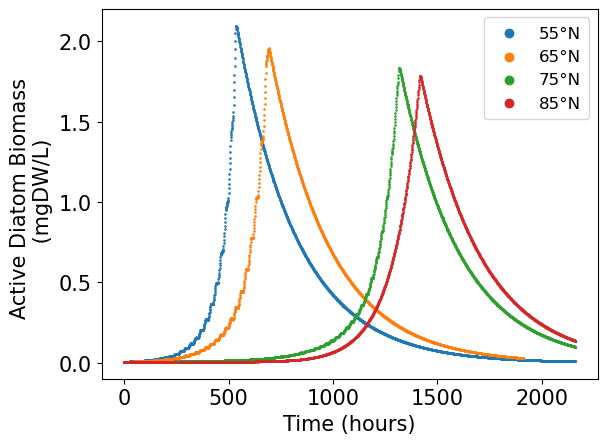

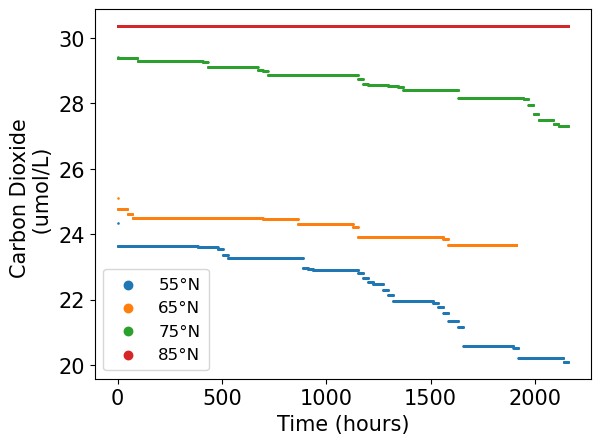

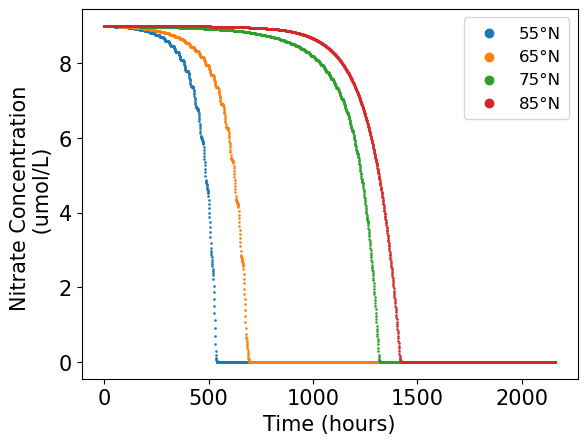

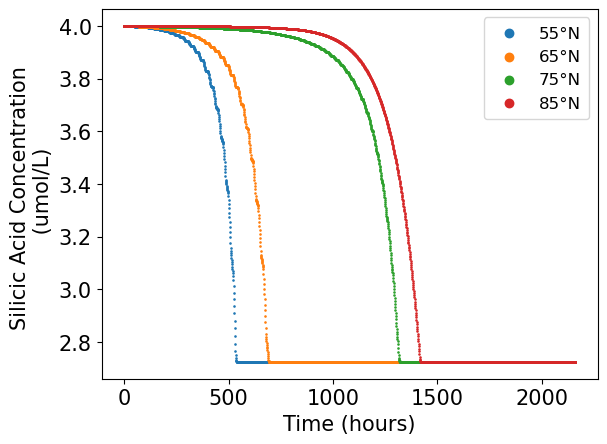

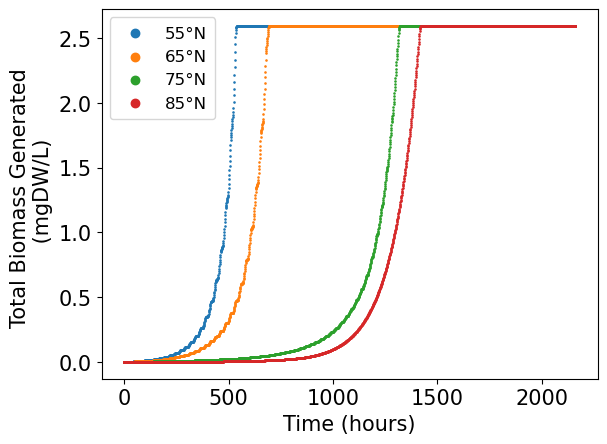

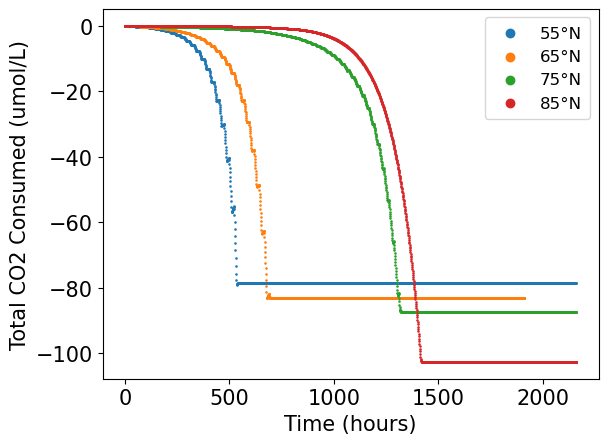

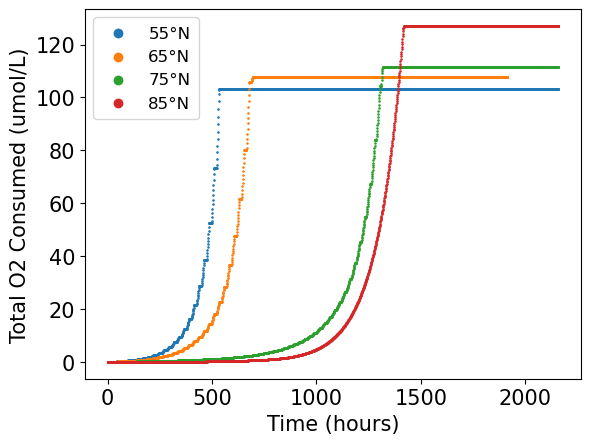

In [6]:
x = arraydict['arraytime']
lats = [55, 65, 75, 85]
variables = ['arraybio','arrayCO2','arrayNO3','arraySiO4H4','arraytotalBM','arraytotalCO2','arraytotalO2']
labels = ["Active Diatom Biomass \n (mgDW/L)","Carbon Dioxide \n (umol/L)","Nitrate Concentration \n (umol/L)",
           "Silicic Acid Concentration \n (umol/L)","Total Biomass Generated \n (mgDW/L)",
          "Total CO2 Consumed (umol/L)","Total O2 Consumed (umol/L)"]
filenames = ["Bio","CO2","Nitrate","Silicic","TotalBio","TotalCO2","TotalO2"]

for idx, name in enumerate(filenames):
    plt.figure()
            
    for idy, lat in enumerate(lats):
        plt.scatter(x[idy,:],arraydict[variables[idx]][idy,:],s=0.75)

    plt.xlabel("Time (hours)")
    plt.ylabel(labels[idx]) 
    plt.legend(["55"+chr(176)+"N","65"+chr(176)+"N","75"+chr(176)+"N","85"+chr(176)+"N",],markerscale=7,
              borderpad=0.5,labelspacing=0.5)

    plt.rc('font', size=15)          # controls default text sizes
    plt.rc('axes', titlesize=15)     # fontsize of the axes title
    plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
    plt.rc('legend', fontsize=12)    # legend fontsize
    plt.rc('figure', titlesize=12)  # fontsize of the figure title
    plt.savefig(("Diatom-OnlyMarch " + name + ".pdf"),dpi=1200,format='pdf')

In [7]:
CO2Int = []
idstop = []
for idy, lat in enumerate(lats):
    idstop.append(np.where(arraydict['arrayNO3'][idy]==0)[0][0])
    CO2Scale = arraydict['arraytotalCO2'][idy,-1]*(44000/1000000)
    print(arraydict['arraytotalCO2'][idy,-1])
    CO2Int.append(CO2Scale)
CO2Int

-78.6419790717863
-83.19706072913021
-87.25996008185386
-102.64449606344454


[-3.460247079158597,
 -3.660670672081729,
 -3.8394382436015695,
 -4.516357826791559]

In [12]:
x[0,idstop[0]]/24

22.510064178298293

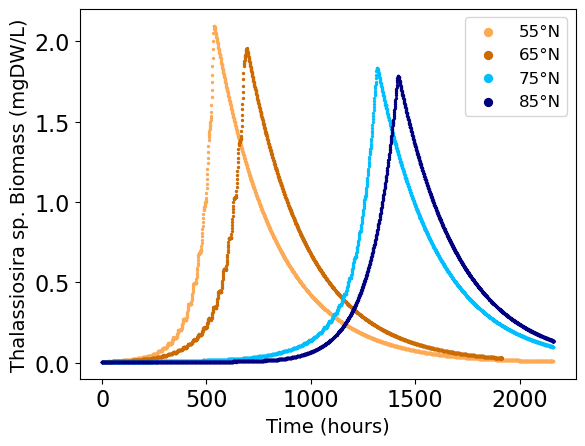

In [15]:
x = arraydict['arraytime']
lats = [55, 65, 75, 85]
variables = ['arraybio','arrayCO2','arrayNO3','arraySiO4H4','arraytotalBM']
colors = ['#fcaa53','#cc6a04','deepskyblue','navy']
for idy, lat in enumerate(lats):
    plt.scatter(x[idy,:],arraydict['arraybio'][idy,:],s=2,c=colors[idy])

plt.xlabel("Time (hours)")
plt.ylabel("Thalassiosira sp. Biomass (mgDW/L)")
plt.legend(["55"+chr(176)+"N","65"+chr(176)+"N","75"+chr(176)+"N","85"+chr(176)+"N"],markerscale=4)

plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title
plt.savefig(("Figure1.pdf"),dpi=1200,format='pdf',bbox_inches='tight')

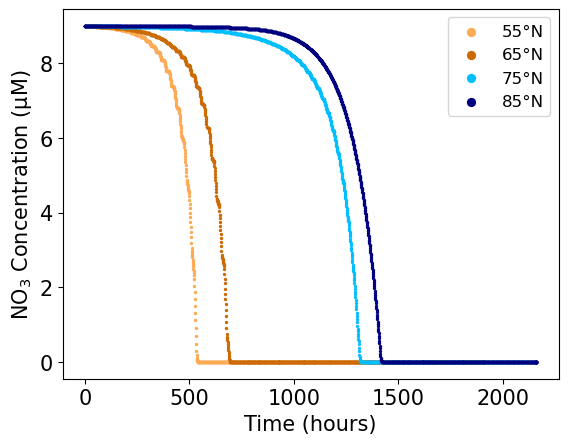

In [9]:
x = arraydict['arraytime']
lats = ['55', '65', '75', '85']
colors = ['#fcaa53','#cc6a04','deepskyblue','navy']
for idy, lat in enumerate(lats):
    plt.scatter(x[idy,:],arraydict['arrayNO3'][idy,:],s=2,color=colors[idy],label=lat+chr(176)+"N")

plt.xlabel("Time (hours)")
plt.ylabel(u"$\mathregular{NO_3}$ Concentration (\u03bcM)") 
plt.legend(["55"+chr(176)+"N","65"+chr(176)+"N",
            "75"+chr(176)+"N","85"+chr(176)+"N"],markerscale=4)

plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title
plt.savefig(("Figure2a.pdf"),dpi=1200,format='pdf',bbox_inches='tight')

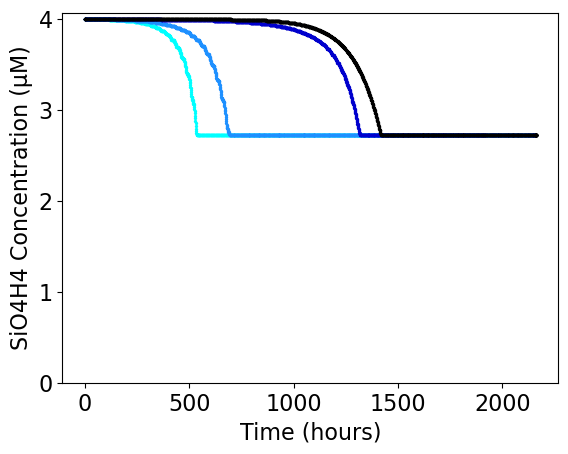

In [29]:
lats = ['55', '65', '75', '85']
colors = ['aqua','dodgerblue','mediumblue','black']
for idy, lat in enumerate(lats):
    plt.scatter(x[idy,:],arraydict['arraySiO4H4'][idy,:],s=2,color=colors[idy])

plt.xlabel("Time (hours)")
plt.ylabel(u"SiO4H4 Concentration (\u03bcM)") 
plt.ylim(bottom=0)

plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title
plt.savefig(("Figure2b.pdf"),dpi=1200,format='pdf',bbox_inches='tight')

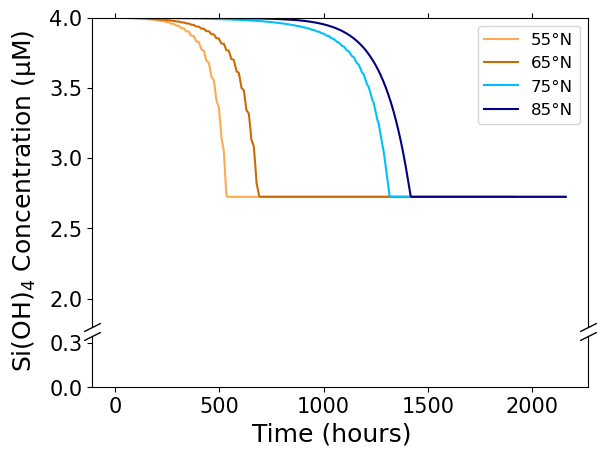

In [8]:
np.random.seed(19680801)

# If we were to simply plot pts, we'd lose most of the interesting
# details due to the outliers. So let's 'break' or 'cut-out' the y-axis
# into two portions - use the top (ax1) for the outliers, and the bottom
# (ax2) for the details of the majority of our data
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[6,1])
fig.subplots_adjust(hspace=0.05)  # adjust space between Axes

# plot the same data on both Axes
for idy, lat in enumerate(lats):
    ax1.plot(x[idy,:],arraydict['arraySiO4H4'][idy,:],markersize=50,color=colors[idy])
    ax2.plot(x[idy,:],arraydict['arraySiO4H4'][idy,:],markersize=50,color=colors[idy])

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(1.8, 4)  # all data
ax2.set_ylim(0, 0.35)  # chop it low

ax2.yaxis.set_major_locator(plt.MaxNLocator(1))

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the Axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the Axes size or scale
# Finally, we need to disable clipping.

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

fig.supxlabel("Time (hours)",y=-0.0125)
fig.supylabel(u"$\mathregular{Si(OH)_4}$ Concentration (\u03bcM)",x=-0.0035)

fig.legend(["55"+chr(176)+"N","65"+chr(176)+"N",
            "75"+chr(176)+"N","85"+chr(176)+"N"],markerscale=6,loc='upper right',
              bbox_to_anchor=(0.9,0.88))

plt.savefig(("Figure2b.pdf"),dpi=1200,format='pdf',bbox_inches='tight')